In [1]:
!pip install timm scikit-learn

  Obtaining dependency information for timm from https://files.pythonhosted.org/packages/6c/d0/179abca8b984b3deefd996f362b612c39da73b60f685921e6cd58b6125b4/timm-1.0.15-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/52.0 kB ? eta -:--:--
     -------------------------------------- 52.0/52.0 kB 889.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.4 MB 1.3 MB/s eta 0:00:02
   - -------------------------------------- 0.1/2.4 MB 1.1 MB/s eta 0:00:03
   --- ------------------------------------ 0.2/2.4 MB 1.5 MB/s eta 0:00:02
   ---- ----------------------------------- 0.3/2.4 MB 1.3 MB/s eta 0:00:02
   ----- ---------------------------------- 0.3/2.4 MB 1.4 MB/s eta 0:00:02
   ----- ---------------------------------- 0.3/2.4 MB 1.0 MB/s eta 0:00:02
   ------- -------------------------------- 0.4/2.4 MB 1.3 M

In [2]:
import os
import torch
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import timm
import torch.nn as nn
from tqdm import tqdm

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # convert 1-channel to 3-channel
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
import zipfile
import os

os.makedirs("data", exist_ok=True)

with zipfile.ZipFile("HATE MEL SPECTROGRAMS.zip", "r") as zip_ref:
    zip_ref.extractall("data")

with zipfile.ZipFile("NON HATE MEL SPECTROGRAMS.zip", "r") as zip_ref:
    zip_ref.extractall("data")

In [9]:
import os

print("HATE contents:", os.listdir("data/HATE MEL SPECTROGRAMS")[:5])
print("NON-HATE contents:", os.listdir("data/NON HATE MEL SPECTROGRAMS")[:5])


HATE contents: ['A_1.wav_mel_spectrogram.png', 'A_10.wav_mel_spectrogram.png', 'A_100.wav_mel_spectrogram.png', 'A_101.wav_mel_spectrogram.png', 'A_102.wav_mel_spectrogram.png']
NON-HATE contents: ['SAMPLE 1.png', 'SAMPLE 10.png', 'SAMPLE 100.png', 'SAMPLE 101.png', 'SAMPLE 102.png']


In [10]:
dataset = CustomMelSpectrogramDataset(
    hate_dir='data/HATE MEL SPECTROGRAMS',
    non_hate_dir='data/NON HATE MEL SPECTROGRAMS',
    transform=transform
)

In [11]:
from torch.utils.data import Dataset
from PIL import Image

class CustomMelSpectrogramDataset(Dataset):
    def __init__(self, hate_dir, non_hate_dir, transform=None):
        self.transform = transform
        self.data = []

        # Label 1 for HATE
        for img in os.listdir(hate_dir):
            self.data.append((os.path.join(hate_dir, img), 1))

        # Label 0 for NON-HATE
        for img in os.listdir(non_hate_dir):
            self.data.append((os.path.join(non_hate_dir, img), 0))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [12]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from timm import create_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

# Extract labels for StratifiedKFold
labels = [label for _, label in dataset]

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(np.zeros(len(dataset)), labels)):
    print(f"\n=== Fold {fold+1} ===")

    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=16, shuffle=True)
    val_loader = DataLoader(Subset(dataset, val_idx), batch_size=16, shuffle=False)

    model = create_model('vit_base_patch16_224', pretrained=True, num_classes=2)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=3e-5)

    # Train loop (1 epoch to keep it quick — adjust as needed)
    model.train()
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    fold_accuracies.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.2f}%")

print("\n=== Cross-validation Results ===")
print(f"Average Accuracy: {np.mean(fold_accuracies):.2f}%")


Using cpu

=== Fold 1 ===


C:\Users\srivi\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\srivi\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Validating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.33s/it]


Fold 1 Accuracy: 97.78%

=== Fold 2 ===


Validating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.44s/it]


Fold 2 Accuracy: 100.00%

=== Fold 3 ===


Validating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.84s/it]


Fold 3 Accuracy: 97.78%

=== Fold 4 ===


Validating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.19s/it]


Fold 4 Accuracy: 100.00%

=== Fold 5 ===


Validating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.79s/it]

Fold 5 Accuracy: 95.56%

=== Cross-validation Results ===
Average Accuracy: 98.22%


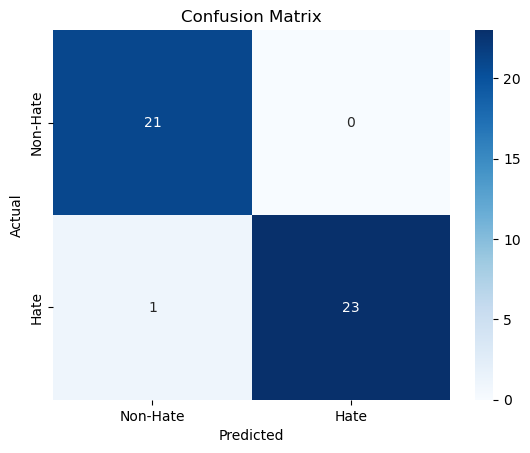

              precision    recall  f1-score   support

    Non-Hate       0.95      1.00      0.98        21
        Hate       1.00      0.96      0.98        24

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# After model.eval() in the final fold
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Hate", "Hate"], yticklabels=["Non-Hate", "Hate"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=["Non-Hate", "Hate"]))


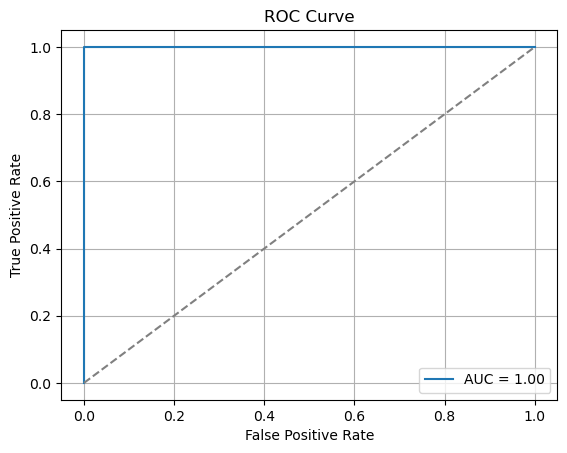

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

y_probs = []  # model output probabilities for class 1 (HATE)

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        y_probs.extend(probs[:, 1].cpu().numpy())  # class 1 probs

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
auc = roc_auc_score(y_true, y_probs)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

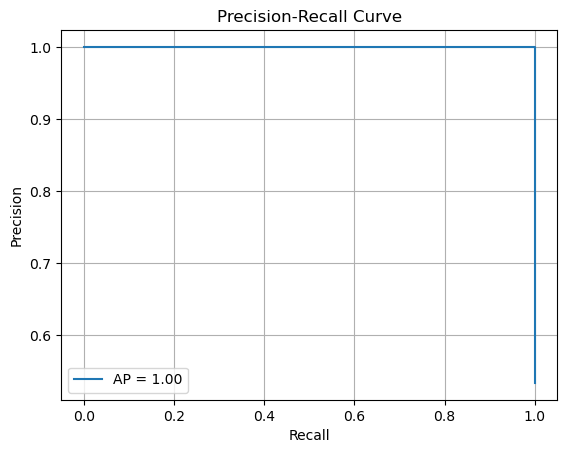

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_true, y_probs)
ap = average_precision_score(y_true, y_probs)

plt.plot(recall, precision, label=f"AP = {ap:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()
